# **Gesture Recognition**

We want to develop a feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command as shown below: </br>

Gesture     | Command
----------  |----------
Thumbs up   | Increase the volume
Thumbs down | Decrease the volume
Left swipe  | 'Jump' backwards 10 seconds
Right swipe | 'Jump' forward 10 seconds
Stop        | Pause the movie



## **GPU Setup and Loading Libraries**

#### Load Libraries

In [ ]:
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
!pip install scipy==1.2.1
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Check python version

In [ ]:
!python --version 

Python 3.7.13


#### Check GPU setup

In [ ]:
import tensorflow as tf
!nvidia-smi 
!nvcc --version
tf.test.gpu_device_name()

Wed Sep 14 11:14:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

'/device:GPU:0'

## **Setting parameters**

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
import scipy.stats
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

#### Defining Class: InitParameters

In [ ]:
# of classes = 5
# of channels = 3 
# frames per video = 30

# Class InitParameters for setting parameters for different models
class InitParameters():

    # Function for defining project path
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self, image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the batch size, frames to sample and epochs
    def initialize_hyperparams(self, frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

In [ ]:
# unit test params
params = InitParameters()
params.initialize_image_properties(120,120)
print(params.image_height)

120


#### Plot Function 

In [ ]:
# Function to plot the training/validation accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## **Importing Data**

The training data consists of a few hundred videos categorised into one of the five classes. Each video is divided into a sequence of 30 frames. These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. </br>
We read the training and validation datasets. We also set the `batch_size` here. The batch size is set in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

#### Setting the path to project folder

In [ ]:
project_folder = 'Project_data'

In [ ]:
#unzip the data set
from zipfile import ZipFile
file_name = "gesture-recognition.zip"

print(file_name)

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

gesture-recognition.zip
Done


In [ ]:
# test and validation docs
train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/val.csv').readlines())

#### Looking at the train and validation datsets

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20     #experiment with the batch size
print ('batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
batch_size = 20


## **Generator**
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We will experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy. </br>
The goal is that the generator is be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

In [ ]:
 # generator function for creating batches of video frames for processing
 # Used during model training

def generator(params, source_path, folder_list, augment=False):
        batch_size = params.batch_size  
        print( 'Source path = ', source_path, '; batch size =', batch_size)
         
      # create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,params.total_frames-1, params.frames_to_sample)).astype(int)
       
        while True:
            # shuffle the training doc
            t = np.random.permutation(folder_list) 
      
            # calculate the number of batches   
            num_batches = len(t)//batch_size          
        
            # for each complete batch
            for batch in range(num_batches): 
                batch_data, batch_labels= batch_processing(params,source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels   # yield the batch_data and the batch_labels

            # process the remaining sequence
            pending_seq=len(t)%batch_size      
            if (pending_seq != 0):
                batch_data, batch_labels= batch_processing(params,source_path,t,num_batches,batch_size,img_idx,augment,pending_seq)
                yield batch_data, batch_labels  # yield the batch_data and the batch_labels


 # Function for single batch processing
 # Used by the generator
  
def batch_processing(params,source_path,t,batch,batch_size,img_idx,augment=False,pending_seq=0):
    
        seq_len = pending_seq if pending_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),params.image_height,params.image_width,params.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len,params.num_classes))   # batch_labels is the one hot representation of the output
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),params.image_height,params.image_width,params.channels))

        
        for folder in range(seq_len): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx):  #  Iterate over the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(params.image_height,params.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255   #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                  
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(params.image_height,params.image_width,3))
                  
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)                

## **Model**
Here we make the model using different functionalities that Keras provides. We will be using `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would use `TimeDistributed` while building a Conv2D + RNN model. Also, the last layer is the softmax. </br>
The goal is to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### **Loading the libraries**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
import abc
from sys import getsizeof

### **Abstract Class: ModelBuilder**


In [ ]:
# Abstract class to define the basic functionalities for each model class 
class ModelBuilder(metaclass= abc.ABCMeta):

# Setting the parameters
  def __init__(self, params):
    self.params = params

# Training the model
  def train_model(self, model, augment_data=False):
        train_generator = generator(params, params.train_path, params.train_doc, augment=augment_data)
        val_generator = generator(params, params.val_path, params.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

   # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

   # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
        if (params.num_train_sequences%params.batch_size) == 0:
            steps_per_epoch = int(params.num_train_sequences/params.batch_size)
        else:
            steps_per_epoch = (params.num_train_sequences//params.batch_size) + 1

        if (params.num_val_sequences%params.batch_size) == 0:
            validation_steps = int(params.num_val_sequences/params.batch_size)
        else:
            validation_steps = (params.num_val_sequences//params.batch_size) + 1

    # Model fitting
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=params.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

  @abc.abstractmethod
  def define_model(self):
        pass        

### **Basic 3DConv Model**

3D Conv model with (3,3,3) filter. </br>
4 convolution layers followed by flattening and fully connected dense layers. </br>
Finally, a softmax layer with 5 neurons.

#### Define the Model

In [ ]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self):
    
     # define the model
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(params.num_classes,activation='softmax'))

    # compile the model
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  
        print (model.summary())   # when we print the summary we will see the number of parameters to train
        return model


#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)

print(params)

# build the model
conv_3d = ModelConv3D(params)
conv_3d_model = conv_3d.define_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

#### Memory Utilization

In [ ]:
print("Memory utilization is {:4.2f} GB". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory utilization is 3.66 GB


###**Selecting the batch size**

In [ ]:
# Batch size 60, frames 30, Image 160x160
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)


conv_3d_b1=ModelConv3D(params)
conv_3d_b1_model=conv_3d_b1.define_model()
print("Total Params:", conv_3d_b1_model.count_params())
conv_3d_b1.train_model(conv_3d_b1_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 15, 80, 80, 32)   

None
Total Params: 1736389
Source path =  Project_data/train ; batch size = 60
Epoch 1/2


ResourceExhaustedError: ignored

In [ ]:
# Batch size 60, frames 20, Image 100x100
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=100,image_width=100)
params.initialize_hyperparams(frames_to_sample=20,batch_size=60,num_epochs=2)

conv_3d_b2=ModelConv3D(params)
conv_3d_b2_model=conv_3d_b2.define_model()
print("Total Params:", conv_3d_b2_model.count_params())
conv_3d_b2.train_model(conv_3d_b2_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 50, 50, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 10, 50, 50, 32)   

None
Total Params: 687813
Source path =  Project_data/train ; batch size = 60
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.7196 - categorical_accuracy: 0.3665Source path =  Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2022-09-1410_38_33.681369/model-00001-1.71963-0.36652-1.56383-0.29000.h5
12/12 [==============================] - 63s 6s/step - loss: 1.7196 - categorical_accuracy: 0.3665 - val_loss: 1.5638 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 3s - loss: 1.2011 - categorical_accuracy: 0.5364
Epoch 2: saving model to model_init_2022-09-1410_38_33.681369/model-00002-1.20627-0.53695-2.37723-0.18000.h5
12/12 [==============================] - 53s 5s/step - loss: 1.2063 - categorical_accuracy: 0.5370 - val_loss: 2.3772 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [ ]:
# Batch size 30, frames 30, Image 160x160
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)


conv_3d_b3=ModelConv3D(params)
conv_3d_b3_model=conv_3d_b3.define_model()
print("Total Params:", conv_3d_b3_model.count_params())
conv_3d_b3.train_model(conv_3d_b3_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 15, 80, 80, 32)   

None
Total Params: 1736389
Source path =  Project_data/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6825 - categorical_accuracy: 0.3906Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-1410_47_03.271951/model-00001-1.68247-0.39065-3.51809-0.16000.h5
23/23 [==============================] - 120s 5s/step - loss: 1.6825 - categorical_accuracy: 0.3906 - val_loss: 3.5181 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0008 - categorical_accuracy: 0.6561
Epoch 2: saving model to model_init_2022-09-1410_47_03.271951/model-00002-1.00077-0.65611-6.58420-0.24000.h5
23/23 [==============================] - 109s 5s/step - loss: 1.0008 - categorical_accuracy: 0.6561 - val_loss: 6.5842 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [ ]:
# Batch size 30, frames 20, Image 100x100
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=100,image_width=100)
params.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=2)

conv_3d_b4=ModelConv3D(params)
conv_3d_b4_model=conv_3d_b4.define_model()
print("Total Params:", conv_3d_b4_model.count_params())
conv_3d_b4.train_model(conv_3d_b4_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 activation_17 (Activation)  (None, 10, 50, 50, 32)   

None
Total Params: 687813
Source path =  Project_data/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6163 - categorical_accuracy: 0.3906Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-1410_51_39.752142/model-00001-1.61626-0.39065-1.75698-0.16000.h5
23/23 [==============================] - 64s 3s/step - loss: 1.6163 - categorical_accuracy: 0.3906 - val_loss: 1.7570 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
22/23 [===========================>..] - ETA: 1s - loss: 1.1666 - categorical_accuracy: 0.5258
Epoch 2: saving model to model_init_2022-09-1410_51_39.752142/model-00002-1.17094-0.52489-3.04493-0.11000.h5
23/23 [==============================] - 53s 2s/step - loss: 1.1709 - categorical_accuracy: 0.5249 - val_loss: 3.0449 - val_categorical_accuracy: 0.1100 - lr: 0.0010


In [ ]:
# Batch size 15, frames 30, Image 160x160
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)


conv_3d_b5=ModelConv3D(params)
conv_3d_b5_model=conv_3d_b5.define_model()
print("Total Params:", conv_3d_b5_model.count_params())
conv_3d_b5.train_model(conv_3d_b5_model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 15, 80, 80, 32)   

None
Total Params: 1736389
Source path =  Project_data/train ; batch size = 15
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6808 - categorical_accuracy: 0.3650Source path =  Project_data/val ; batch size = 15

Epoch 1: saving model to model_init_2022-09-1410_53_40.335488/model-00001-1.68078-0.36501-11.71057-0.16000.h5
45/45 [==============================] - 112s 3s/step - loss: 1.6808 - categorical_accuracy: 0.3650 - val_loss: 11.7106 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.3449 - categorical_accuracy: 0.4887
Epoch 2: saving model to model_init_2022-09-1410_53_40.335488/model-00002-1.34488-0.48869-14.96702-0.16000.h5
45/45 [==============================] - 111s 3s/step - loss: 1.3449 - categorical_accuracy: 0.4887 - val_loss: 14.9670 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
# Batch size 15, frames 20, Image 100x100
# setting params
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=100,image_width=100)
params.initialize_hyperparams(frames_to_sample=20,batch_size=15,num_epochs=2)


conv_3d_b6=ModelConv3D(params)
conv_3d_b6_model=conv_3d_b6.define_model()
print("Total Params:", conv_3d_b6_model.count_params())
conv_3d_b6.train_model(conv_3d_b6_model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 activation_25 (Activation)  (None, 10, 50, 50, 32)   

None
Total Params: 687813
Source path =  Project_data/train ; batch size = 15
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5737 - categorical_accuracy: 0.3771Source path =  Project_data/val ; batch size = 15

Epoch 1: saving model to model_init_2022-09-1410_57_25.902276/model-00001-1.57367-0.37707-3.91703-0.25000.h5
45/45 [==============================] - 73s 2s/step - loss: 1.5737 - categorical_accuracy: 0.3771 - val_loss: 3.9170 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1449 - categorical_accuracy: 0.5490
Epoch 2: saving model to model_init_2022-09-1410_57_25.902276/model-00002-1.14486-0.54902-6.75913-0.17000.h5
45/45 [==============================] - 67s 2s/step - loss: 1.1449 - categorical_accuracy: 0.5490 - val_loss: 6.7591 - val_categorical_accuracy: 0.1700 - lr: 0.0010


Image resolution and number of frames in sequence have more impact on training time than batch_size.
Keeping batch size fixed around 15-40 and changing the image parameters based on the device memory constraints . Models will be designed such that their memory foot print is not huge.

### **Model 1: Base Model with no Augmentation and Batch Size: 40, Epochs = 15**

#### Define the Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)

print(params)
# create the model
conv_3d1=ModelConv3D1(params)
conv_3d1_model=conv_3d1.define_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

#### Train the Model

In [ ]:
print(conv_3d1_model)
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Source path =  Project_data/train ; batch size = 40
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6093 - categorical_accuracy: 0.3922Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2022-09-1411_16_15.172404/model-00001-1.60928-0.39216-1.65031-0.23000.h5
17/17 [==============================] - 90s 5s/step - loss: 1.6093 - categorical_accuracy: 0.3922 - val_loss: 1.6503 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0376 - categorical_accuracy: 0.5897
Epoch 2: saving model to model_init_2022-09-1411_16_15.172404/model-00002-1.03758-0.58974-1.71913-0.24000.h5
17/17 [==============================] - 70s 4s/step - loss: 1.0376 - categorical_accuracy: 0.5897 - val_loss: 1.7191 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8614 - categorical_accuracy: 0.6531
Epoch 3:

#### Accuracy Plot

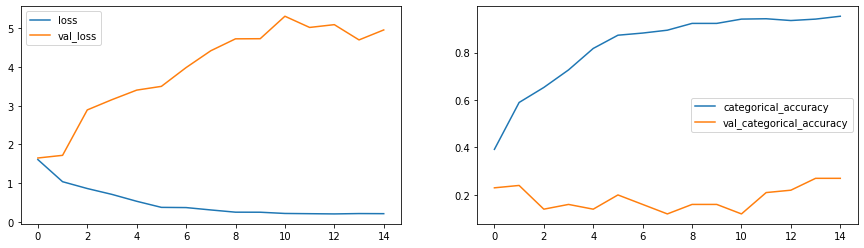

In [ ]:
plot(history_model1)

The model is overfitting and the validation accuracy is very low.

### **Model 2: (3,3,3) Filter and 160x160 Image for Conv 3D**

#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)

# model building
conv_3d2=ModelConv3D1(params)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

#### Train the Model

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Source path =  Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9481 - categorical_accuracy: 0.3688Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1411_33_11.911712/model-00001-1.94812-0.36878-1.83599-0.25000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.9481 - categorical_accuracy: 0.3688 - val_loss: 1.8360 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6266 - categorical_accuracy: 0.4404
Epoch 2: saving model to model_init_2022-09-1411_33_11.911712/model-00002-1.62664-0.44042-1.63614-0.32000.h5
34/34 [==============================] - 122s 4s/step - loss: 1.6266 - categorical_accuracy: 0.4404 - val_loss: 1.6361 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2128 - categorical_accuracy: 0.5777
Epoch 

#### Accuracy Plot

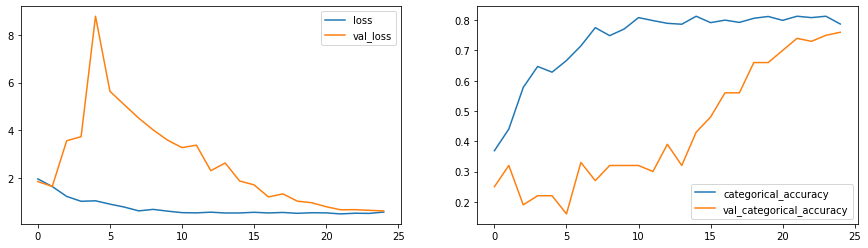

In [ ]:
plot(history_model2)

### **Model 3: (2,2,2) Filter and 120x120 Image with Conv3D**

#### Define the Model

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)

# model building
conv_3d3=ModelConv3D3(params)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_56 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_57 (Activation)  (None, 8, 60, 60, 32)   

#### Train the Model 

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Source path =  Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0572 - categorical_accuracy: 0.3462Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-1414_31_37.591367/model-00001-2.05725-0.34615-2.13908-0.16000.h5
23/23 [==============================] - 87s 4s/step - loss: 2.0572 - categorical_accuracy: 0.3462 - val_loss: 2.1391 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5294 - categorical_accuracy: 0.4713
Epoch 2: saving model to model_init_2022-09-1414_31_37.591367/model-00002-1.52940-0.47134-3.66390-0.15000.h5
23/23 [==============================] - 80s 4s/step - loss: 1.5294 - categorical_accuracy: 0.4713 - val_loss: 3.6639 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
22/23 [===========================>..] - ETA: 3s - loss: 1.2893 - categorical_accuracy: 0.5280


#### Accuracy Plot

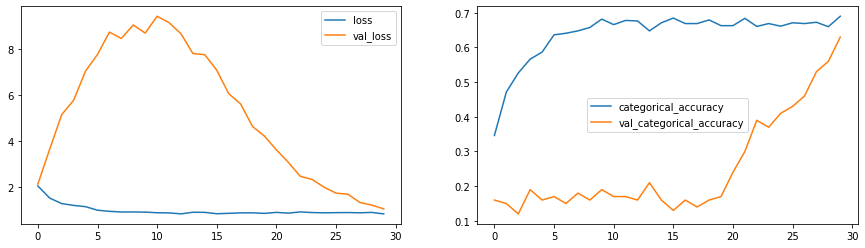

In [ ]:
plot(history_model3)

### **Model 4: Reducing the parameters for Conv3D**

#### Define the Model

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=100,image_width=100)
params.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)

# model building
conv_3d4=ModelConv3D4(params)
conv_3d4_model=conv_3d4.define_model(dense_neurons=128,dropout=0.25)
conv_3d4_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 50, 50, 32)    

#### Train the Model

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 696645
Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0105 - categorical_accuracy: 0.3009Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1412_29_03.220393/model-00001-2.01050-0.30090-1.93392-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 2.0105 - categorical_accuracy: 0.3009 - val_loss: 1.9339 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4562 - categorical_accuracy: 0.4593
Epoch 2: saving model to model_init_2022-09-1412_29_03.220393/model-00002-1.45617-0.45928-2.84293-0.16000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.4562 - categorical_accuracy: 0.4593 - val_loss: 2.8429 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1568 - categorical_accuracy: 0.5603
E

#### Accuracy Plot

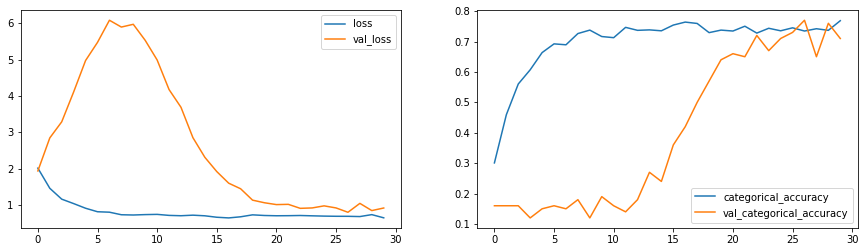

In [ ]:
plot(history_model4)

###**Model 5: Further Reducing the parameters for Conv3D**

#### Define the Model

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

      # define the model
        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)

# model building
conv_3d5=ModelConv3D5(params)
conv_3d5_model=conv_3d5.define_model(dense_neurons=64,dropout=0.25)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_33 (Activation)  (None, 8, 60, 60, 16)    

#### Train the Model

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

#### Accuracy Plot

In [ ]:
plot(history_model5)

### **Model 6: CNN + LSTM**

#### Define the Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    # define the model
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(params.num_classes, activation='softmax'))

      # compile the model  
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# set the parameters for the model
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

# model building
rnn_cnn1=RNNCNN1(params)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 18, 60, 60, 32) 

Train the Model

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4691 - categorical_accuracy: 0.3401Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1413_59_12.160240/model-00001-1.46914-0.34012-1.71034-0.20000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.4691 - categorical_accuracy: 0.3401 - val_loss: 1.7103 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2190 - categorical_accuracy: 0.4887
Epoch 2: saving model to model_init_2022-09-1413_59_12.160240/model-00002-1.21897-0.48869-2.57384-0.23000.h5
34/34 [==============================] - 93s 3s/step - loss: 1.2190 - categorical_accuracy: 0.4887 - val_loss: 2.5738 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1479 - categorical_accuracy: 0.5309
Epoch 3

#### Accuracy Plot

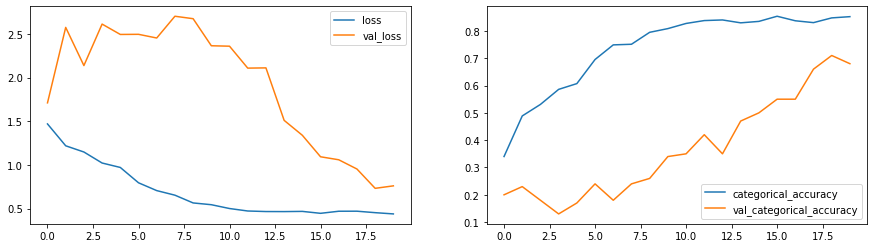

In [ ]:
plot(history_model6)

### **Model 7: (3,3,3) Filter with 160x160 Image for CNN+LSTM**


#### Define the Model

In [ ]:
class ModelConv3DRNN7(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
       # define the model
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(params.num_classes,activation='softmax'))

      #compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)

#model building
conv_rnn_7=ModelConv3DRNN7(params)
conv_rnn_7_model=conv_rnn_7.define_model(dense_neurons=256,dropout=0.5)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_59 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_37 (Activation)  (None, 10, 80, 80, 32)  

#### Train the Model

In [ ]:
print("Total Params:", conv_rnn_7_model.count_params())
history_model7=conv_rnn_7.train_model(conv_rnn_7_model,augment_data=True)

#### Accuracy Plot

In [ ]:
plot(history_model7)

### **Model 8: (2,2,2) Filter with 120x120 Image for CNN+LSTM**

#### Define the Model

In [ ]:
class ModelConv3DRNN8(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
      # define the model
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)

#model building
conv_rnn_8=ModelConv3DRNN8(params)
conv_rnn_8_model=conv_rnn_8.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_65 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_41 (Activation)  (None, 8, 60, 60, 32)   

#### Train the Model

In [ ]:
print("Total Params:", conv_rnn_8_model.count_params())
history_model8=conv_rnn_8.train_model(conv_rnn_8_model,augment_data=True)

#### Accuracy Plot

In [ ]:
plot(history_model8)

### **Model 9: Reducing the parameters for CNN+LSTM**

#### Define the Model

In [ ]:
class ModelConv3DRNN9(ModelBuilder):
    # define the model
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(params.num_classes,activation='softmax'))

      # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=100,image_width=100)
params.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)

# model building
conv_rnn_9=ModelConv3DRNN9(params)
conv_rnn_9_model=conv_rnn_9.define_model(dense_neurons=128,dropout=0.25)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_85 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_53 (Activation)  (None, 8, 50, 50, 32)   

#### Train the Model

In [ ]:
print("Total Params:", conv_rnn_9_model.count_params())
history_model9=conv_rnn_9.train_model(conv_rnn_9_model,augment_data=True)

Total Params: 696645
Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8650 - categorical_accuracy: 0.3175Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1413_18_16.093241/model-00001-1.86503-0.31750-2.01711-0.16000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.8650 - categorical_accuracy: 0.3175 - val_loss: 2.0171 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2545 - categorical_accuracy: 0.5370
Epoch 2: saving model to model_init_2022-09-1413_18_16.093241/model-00002-1.25447-0.53695-2.79371-0.20000.h5
34/34 [==============================] - 77s 2s/step - loss: 1.2545 - categorical_accuracy: 0.5370 - val_loss: 2.7937 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0490 - categorical_accuracy: 0.6078
E

#### Acccuracy Plot

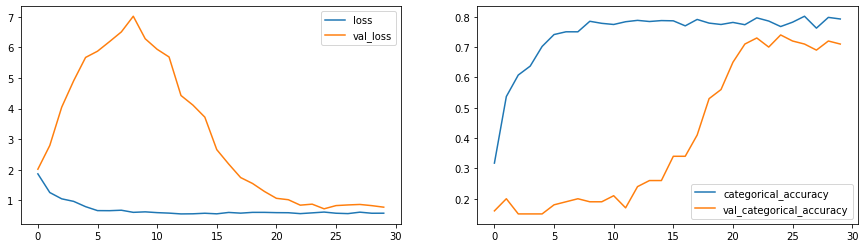

In [ ]:
plot(history_model9)

### **Model 10: Further reducing the parameters for CNN+LSTM**

#### Define th Model

In [ ]:
class ModelConv3DRNN10(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):
      # define the model
        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(params.num_classes,activation='softmax'))

       # compile the model
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)

# model building
conv_rnn_10=ModelConv3DRNN10(params)
conv_rnn_10_model=conv_rnn_10.define_model(dense_neurons=64,dropout=0.25)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_61 (Activation)  (None, 8, 60, 60, 16)   

#### Train the Model

In [ ]:
print("Total Params:", conv_rnn_10_model.count_params())
history_model10=conv_rnn_10.train_model(conv_rnn_10_model,augment_data=True)

Total Params: 230949
Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0404 - categorical_accuracy: 0.2707Source path =  Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1415_12_30.781934/model-00001-2.04042-0.27074-1.65022-0.16000.h5
34/34 [==============================] - 82s 2s/step - loss: 2.0404 - categorical_accuracy: 0.2707 - val_loss: 1.6502 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5021 - categorical_accuracy: 0.4321
Epoch 2: saving model to model_init_2022-09-1415_12_30.781934/model-00002-1.50210-0.43213-1.94044-0.17000.h5
34/34 [==============================] - 80s 2s/step - loss: 1.5021 - categorical_accuracy: 0.4321 - val_loss: 1.9404 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2372 - categorical_accuracy: 0.5121
E

#### Accuracy Plot

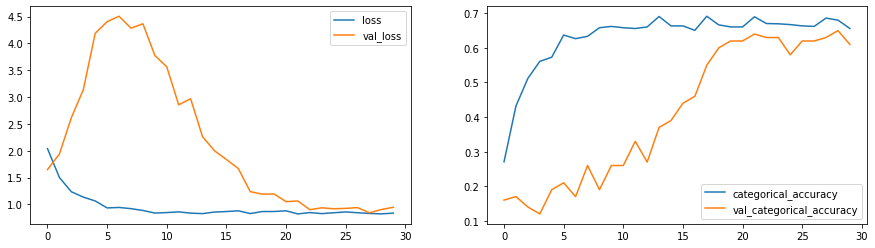

In [ ]:
plot(history_model10)

### **Model 11: Transfer Learning**

MobileNet model is being used as it has less parameters as compared to Inception and Resnet models.

In [ ]:
from keras.applications import mobilenet

#### Define the model

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    # define the model
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(params.num_classes, activation='softmax'))
        
      # complile the model  
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)

# model building
rnn_cnn_tl=RNNCNN_TL(params)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 128)             

#### Train the Model

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model11=rnn_cnn_tl.train_model(rnn_cnn_tl_model)

Total Params: 3840453
Source path =  Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4517 - categorical_accuracy: 0.3846Source path =  Project_data/val ; batch size = 5

Epoch 1: saving model to model_init_2022-09-1416_30_56.070472/model-00001-1.45167-0.38462-1.03290-0.60000.h5
133/133 [==============================] - 108s 789ms/step - loss: 1.4517 - categorical_accuracy: 0.3846 - val_loss: 1.0329 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9423 - categorical_accuracy: 0.6365
Epoch 2: saving model to model_init_2022-09-1416_30_56.070472/model-00002-0.94227-0.63650-0.87763-0.68000.h5
133/133 [==============================] - 54s 411ms/step - loss: 0.9423 - categorical_accuracy: 0.6365 - val_loss: 0.8776 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7472 - categorical_accuracy: 

#### Accuracy Plot

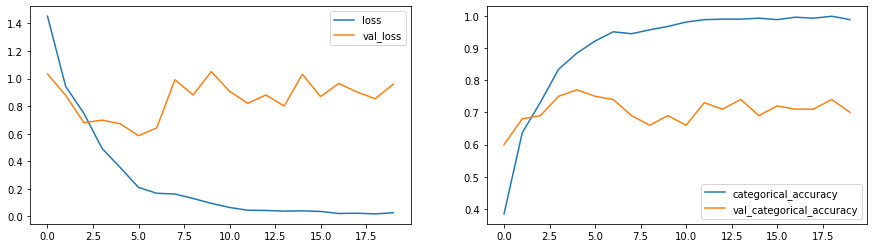

In [ ]:
plot(history_model11)

### **Model 12: Transfer Learning with GRU and training all weights**

#### Define the Model

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
   # define the model 
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(params.frames_to_sample,params.image_height,params.image_width,params.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(params.num_classes, activation='softmax'))
        
      # compile the model  
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

#### Build the Model

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=120,image_width=120)
params.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)

# model building
rnn_cnn_tl2=RNNCNN_TL2(params)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

#### Train the Model

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Source path =  Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1715 - categorical_accuracy: 0.5166Source path =  Project_data/val ; batch size = 5

Epoch 1: saving model to model_init_2022-09-1415_53_59.632375/model-00001-1.17146-0.51659-0.61942-0.77000.h5
133/133 [==============================] - 95s 668ms/step - loss: 1.1715 - categorical_accuracy: 0.5166 - val_loss: 0.6194 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6049 - categorical_accuracy: 0.7564
Epoch 2: saving model to model_init_2022-09-1415_53_59.632375/model-00002-0.60485-0.75641-0.42794-0.83000.h5
133/133 [==============================] - 88s 667ms/step - loss: 0.6049 - categorical_accuracy: 0.7564 - val_loss: 0.4279 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4462 - categorical_accuracy: 0

#### Accuracy Plot

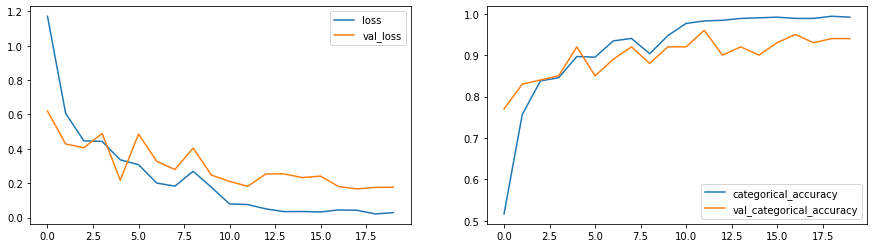

In [ ]:
plot(history_model12)

This model has the best accuracy among all models as: </br>
Train Accuracy: 0.99 </br> 
Val Accuracy: 0.94

### **Model Loading and Testing**

Selecting "Transfer Learining with GRU" with all weights training as the final model for test dataset validation due to its high accuracy on test and val datasets and low losses. 

In [ ]:
import time
from keras.models import load_model
model = load_model('model_init_2022-09-1415_53_59.632375/model-00020-0.02840-0.99170-0.17646-0.94000.h5')

In [ ]:
# parameter setting
params = InitParameters()
params.initialize_path(project_folder)
params.initialize_image_properties(image_height=160,image_width=160)
params.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=1)

#model
model=rnn_cnn_tl2

g = generator(params, params.val_path, params.val_doc,augment=False)
batch_data, batch_labels=next(g)

Source path =  Project_data/val ; batch size = 20


In [ ]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))